<a href="https://colab.research.google.com/github/mohammad2682/FVS-SVM-RKHS/blob/main/SVM_RKHS_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
from sklearn import datasets, svm
import seaborn as sns

In [2]:
N_m=5

In [3]:
import sklearn
A, y=sklearn.datasets.make_classification(n_samples=20,n_features=2,n_informative=2,n_redundant=0,weights=[0.8],random_state=5)
display(A)
display(y)


array([[-2.88470459, -3.09334521],
       [-0.38012753,  0.50960898],
       [ 0.08828312,  0.2825261 ],
       [-1.08727082,  0.91207538],
       [ 0.2095121 ,  1.87770417],
       [-1.26292912,  0.70597421],
       [-1.02649626,  0.67572811],
       [-0.9910247 , -0.92034095],
       [ 0.7250405 ,  1.11196313],
       [-0.82696232,  1.19851322],
       [-1.89255856,  0.40341791],
       [-2.87618154, -3.52767119],
       [-1.20026133, -1.15842117],
       [ 0.04623351,  0.31605039],
       [ 0.2248898 ,  2.1926224 ],
       [ 0.62833321, -2.45446179],
       [-1.87794153, -2.33296202],
       [-1.08536788,  0.91049297],
       [ 0.68698129, -1.99674589],
       [-1.00349992, -1.13101638]])

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])

In [4]:
display(y)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])

In [5]:
def sigma(A):
    N = A.shape[0]
    sigma = []
    for i in range(N):
        for j in range(i+1, N):
            sigma.append(np.square(np.linalg.norm(A[i,:]-A[j,:])))

    return 0.1 * np.max(sigma)

In [6]:
sig=sigma(A)
print(sig)

4.233840225882515


In [7]:
def K(FV1, FV2):
    dist = np.linalg.norm(FV1-FV2)
    return np.exp(-1*np.square(dist)/(2*sig))

In [8]:
def give_KSS(S):
    KSS = []
    for i in S:
        for j in S:
            KSS.append( K(A[i,:], A[j,:]))

    return np.array(KSS).reshape((len(S), len(S)))

In [9]:
def give_KSx(S, x):
    KSx = []
    for i in S:
        kx = K(A[i,:], x)
        KSx.append(kx)
    return np.array(KSx).reshape((len(S), 1))

In [10]:
def give_beta(S, x):
    KSx = give_KSx(S, x).reshape(len(S), 1)
    KSS = give_KSS(S)
    DSS = np.diag(np.diag(np.sqrt(KSS)))
    beta = np.dot(np.dot(np.transpose(KSx), np.linalg.inv(KSS)), DSS)
    return beta

In [17]:
minor_index=np.where(y==1)[0].tolist()
lambdamax=-np.inf
best_iter=-1
counter=0
total_S=[]
lam = []
for i in minor_index:
    current_S=[i]
    ctrl=1
    while (len(current_S)<N_m and ctrl==1):
        current_inv =np.linalg.inv(give_KSS(current_S))
        max_LF=-np.inf
        max_LF_index=-1
        remaining=list(set(range(A.shape[0]))-set(current_S))
        #print(remaining)
        for j in remaining:
            KSx=give_KSx(current_S,A[j,:])
            LF =abs(1-((KSx.T).dot(current_inv).dot(KSx)))
            if LF> max_LF:
                max_LF=LF
                max_LF_index=j
        if(max_LF<0.001):
            ctrl=0
        else:
            current_S.append(max_LF_index)
    total_S.append(current_S)
    
    S0=list(set(current_S)& (set(range(A.shape[0]))-set(minor_index)))
    S1=list(set(current_S) & set(minor_index))
    B0=np.zeros((len(S0),len(current_S) ))
    B1=np.zeros((len(S1), len(current_S)))
    rownum=0
    for k in S0:
        B0[rownum,:]=give_beta(current_S, A[k,:]).flatten()
        rownum=rownum+1
    rownum=0
    for k in S1:
        B1[rownum,:]=give_beta(current_S, A[k,:]).flatten()
        rownum=rownum+1
        
    mean0=B0.mean(axis=0)
    mean1=B1.mean(axis=0)
    
    var0=B0.var(axis=0)
    var1=B1.var(axis=0)
    
    lam.append(((mean0-mean1)**2)/(var0+var1))

    total_lam=np.sum(lam)/np.shape(lam)[0]
    print(total_lam)
    if(lambdamax<total_lam):
        lambdamax=total_lam
        best_iter=counter
    counter=counter+1

print(total_S[best_iter])


A[total_S[best_iter],:]


        
    
    
    

3.5000000000000027
2.248355879203173e+32
2.1982031596754932e+32
[15, 14, 11, 10, 2]


array([[ 0.62833321, -2.45446179],
       [ 0.2248898 ,  2.1926224 ],
       [-2.87618154, -3.52767119],
       [-1.89255856,  0.40341791],
       [ 0.08828312,  0.2825261 ]])

In [18]:
model = svm.SVC(kernel = "rbf", gamma = sig)

In [24]:
model.fit(A[total_S[best_iter],:], y[total_S[best_iter]])

SVC(gamma=4.233840225882515)

In [25]:
model.score(A, y)

0.9

In [27]:
# Enter minor major labels
minor_cls = 0
major_cls = 1
cls_types= np.array([major_cls, minor_cls])

In [28]:
cls_types

array([1, 0])

Text(0.5, 89.87999999999997, 'Predicted')

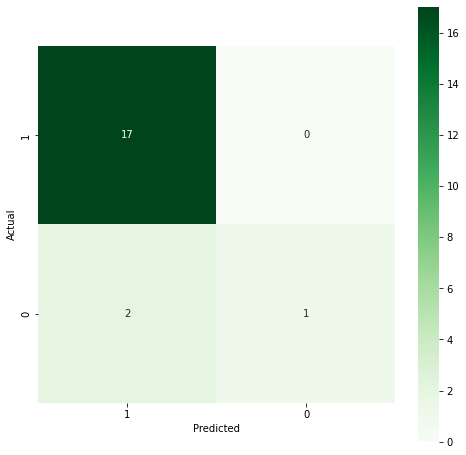

In [29]:
Y_pred = model.predict(A)
Y_true = y
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8, 8))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=cls_types, yticklabels=cls_types)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

In [30]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[0][1]
FP = cm[1][0]

TPR = TP / (TP+FN)
TNR = TN / (TN+FP)
precision = TP / (TP+FP)
recall=TP/(TP+FN)                  

In [31]:
G_mean = np.sqrt(TPR*TNR)
F_measure = (2*precision*TPR)/(precision+TPR)

print(G_mean)
print(F_measure)
print(precision)
print(recall)

0.9459053029269173
0.5
0.3333333333333333
1.0
